## Classification

Here we will bring together various techniques for feature engineering to tackle a classification problem. This would give you an idea of the end-to-end pipeline to build machine learning algorithms for classification. 

I will:
- build a gradient boosted tree
- use feature-engine for the feature engineering steps
- set up an entire engineering and prediction pipeline using a Scikit-learn Pipeline

============================================================================

## In this demo:

We will use the titanic dataset

In [1]:
# import libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from feature_engine import imputation as mdi
from feature_engine import encoding as ce
from feature_engine import discretisation as dsc

In [2]:
# load data
cols = [
    'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin',
    'embarked', 'survived'
]

data = pd.read_csv('titanic.csv', usecols=cols)
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
0,1,1,female,29.0000,0,0,211.3375,B5,S
1,1,1,male,0.9167,1,2,151.5500,C22,S
2,1,0,female,2.0000,1,2,151.5500,C22,S
3,1,0,male,30.0000,1,2,151.5500,C22,S
4,1,0,female,25.0000,1,2,151.5500,C22,S


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1308 non-null   float64
 7   cabin     295 non-null    object 
 8   embarked  1307 non-null   object 
dtypes: float64(2), int64(4), object(3)
memory usage: 92.2+ KB


### Types of variables

Let's find out what types of variables there are in this dataset

In [5]:
data.dtypes

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
cabin        object
embarked     object
dtype: object

- There are categorical and numerical variables

In [7]:
# let's inspect the variable values

for var in data.columns: 
    print(var, data[var].unique()[:20])

pclass [1 2 3]
survived [1 0]
sex ['female' 'male']
age [29.      0.9167  2.     30.     25.     48.     63.     39.     53.
 71.     47.     18.     24.     26.     80.         nan 50.     32.
 36.     37.    ]
sibsp [0 1 2 3 4 5 8]
parch [0 2 1 4 3 5 6 9]
fare [211.3375 151.55    26.55    77.9583   0.      51.4792  49.5042 227.525
  69.3     78.85    30.      25.925  247.5208  76.2917  75.2417  52.5542
 221.7792  26.      91.0792 135.6333]
cabin ['B5' 'C22' 'E12' 'D7' 'A36' 'C101' nan 'C62' 'B35' 'A23' 'B58' 'D15' 'C6'
 'D35' 'C148' 'C97' 'B49' 'C99' 'C52' 'T']
embarked ['S' 'C' nan 'Q']


- There are continuous and discrete variables and also mixed variables.

In [12]:
# make list of variables  types

# numerical: discrete vs continuous
discrete = [var for var in data.columns if data[var].dtype!= 'O' and var!='survived' and data[var].nunique() < 10]
continuous = [var for var in data.columns if data[var].dtype!= 'O' and var!='survived' and var not in discrete]

# mixed
mixed = ['cabin']

# categorical
categorical = [var for var in data.columns if data[var].dtype == 'O' and var!='survived' and var not in mixed]

In [13]:
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))
print('There are {} mixed variables'.format(len(mixed)))

There are 3 discrete variables
There are 2 continuous variables
There are 2 categorical variables
There are 1 mixed variables


In [14]:
discrete

['pclass', 'sibsp', 'parch']

In [15]:
continuous

['age', 'fare']

In [16]:
mixed

['cabin']

In [17]:
categorical

['sex', 'embarked']

### Variable characteristics

In [18]:
# missing data

data.isnull().mean()

pclass      0.000000
survived    0.000000
sex         0.000000
age         0.200917
sibsp       0.000000
parch       0.000000
fare        0.000764
cabin       0.774637
embarked    0.001528
dtype: float64

- We can see there are missing data in our variables

<AxesSubplot:>

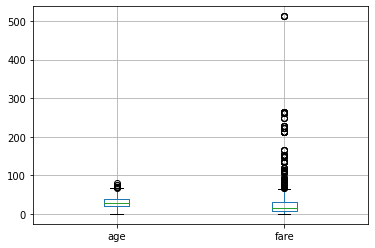

In [19]:
# outliers

data[continuous].boxplot()

<AxesSubplot:>

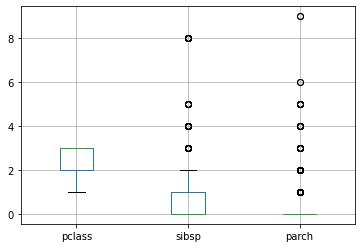

In [20]:
# outliers in discrete
data[discrete].boxplot()

Some variables show outliers or unusual values

In [22]:
# values bigger than 3 are rare for parch

data['parch'].value_counts()

0    1002
1     170
2     113
3       8
4       6
5       6
6       2
9       2
Name: parch, dtype: int64

In [24]:
# similar for sibsp also, values greater than 7 are rare
data['sibsp'].value_counts()

0    891
1    319
2     42
4     22
3     20
8      9
5      6
Name: sibsp, dtype: int64

In [25]:
# feature magnitude

data.describe()

,pclass,survived,age,sibsp,parch,fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


Features are in different ranges or scales. But this is not relevant for gradient boosted trees. 

### Engineering mixed type of variables

Extract numerical and categorical parts of variables.

In [30]:
# Cabin
data['cabin_num'] = data['cabin'].str.extract('(\d+)') # captures numerical part
data['cabin_num'] = data['cabin_num'].astype('float')
data['cabin_cat'] = data['cabin'].str[0] # captures the first letter

# show dataframe
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,cabin_num,cabin_cat
0,1,1,female,29.0000,0,0,211.3375,B5,S,5.0,B
1,1,1,male,0.9167,1,2,151.5500,C22,S,22.0,C
2,1,0,female,2.0000,1,2,151.5500,C22,S,22.0,C
3,1,0,male,30.0000,1,2,151.5500,C22,S,22.0,C
4,1,0,female,25.0000,1,2,151.5500,C22,S,22.0,C


In [31]:
# drop original mixed
data.drop(['cabin'], axis=1, inplace = True)

In [32]:
# separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.1,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1178, 9), (131, 9))

### Missing data imputation

In [34]:
# numerical

X_train.select_dtypes(exclude='O').isnull().mean()

pclass       0.000000
age          0.198642
sibsp        0.000000
parch        0.000000
fare         0.000849
cabin_num    0.782683
dtype: float64

In [35]:
# numerical

X_train.select_dtypes(include='O').isnull().mean()

sex          0.000000
embarked     0.001698
cabin_cat    0.771647
dtype: float64

Imputation methods I will perform:

- Numerical: arbitrary value imputation
- Categorical: add missing label imputation

Because I will build a Gradient Boosted tree, I am not particularly worried about disturbing linearity or distributions of variables.

### Categorical encoding and rare labels

In [36]:
# check cardinality again

X_train[['sex','embarked','cabin_cat']].nunique()

sex          2
embarked     3
cabin_cat    8
dtype: int64

Now that I extracted the numerical and categorical part from cabin, its cardinality is not so high.

In [40]:
# check variable frequency

var = 'cabin_cat'
(X_train[var].value_counts()/len(X_train)).sort_values()

T    0.000849
G    0.003396
A    0.016978
F    0.016978
E    0.033107
D    0.033956
B    0.049236
C    0.073854
Name: cabin_cat, dtype: float64

Categories T and G appear only in few observations, so I will replace them into rare.

### Discretisation or Variable transformation

Let's inspect the variable distributions.

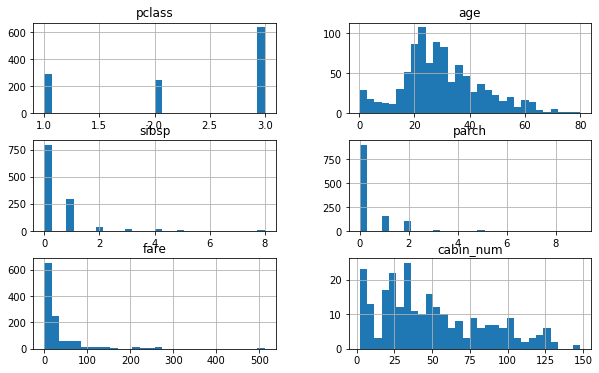

In [43]:
X_train.select_dtypes(exclude='O').hist(bins=30, figsize=(10, 6));

For decision trees, the variable distribution is not so important, so in principle, we don't need to change it. Also decision trees are robust to outliers.

## Putting it all together

In [46]:
titanic_pipe = Pipeline([
    
    # missing data imputation
    ('imputer', mdi.ArbitraryNumberImputer(arbitrary_number=-1,
                                variables=['age', 'fare', 'cabin_num'])),
     
     ('imputer_cat', mdi.CategoricalImputer(variables=['embarked', 'cabin_cat'])),
     
     # categorical encoding
     ('encoder_rare_label', ce.RareLabelEncoder(tol=0.01, n_categories=6, variables=['cabin_cat'])),
     
     ('categorical_encoder', ce.OrdinalEncoder(encoding_method='ordered',
                                              variables=['cabin_cat', 'sex', 'embarked'])),
     
    # Gradient Boosted machine
     ('gbm', GradientBoostingClassifier(random_state=0)),
])

In [47]:
# fit the pipeline

titanic_pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 ArbitraryNumberImputer(arbitrary_number=-1,
                                        variables=['age', 'fare',
                                                   'cabin_num'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['embarked', 'cabin_cat'])),
                ('encoder_rare_label',
                 RareLabelEncoder(n_categories=6, tol=0.01,
                                  variables=['cabin_cat'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['cabin_cat', 'sex', 'embarked'])),
                ('gbm', GradientBoostingClassifier(random_state=0))])

In [48]:
# get predictions

X_train_preds = titanic_pipe.predict_proba(X_train)[:,1]
X_test_preds = titanic_pipe.predict_proba(X_test)[:,1]

In [49]:
X_test_preds

array([0.0689847 , 0.90658578, 0.15908975, 0.06367159, 0.17791482,
       0.74072152, 0.38378954, 0.41451956, 0.05955047, 0.08394796,
       0.08407773, 0.16693395, 0.22860405, 0.43667703, 0.97278257,
       0.1163335 , 0.85664039, 0.35375522, 0.90310204, 0.1122268 ,
       0.10102298, 0.06696516, 0.11081688, 0.98902348, 0.68818959,
       0.76688779, 0.11194896, 0.10702554, 0.18086863, 0.53008098,
       0.85173025, 0.97995342, 0.89212837, 0.22570669, 0.96547644,
       0.17524357, 0.08891292, 0.13770317, 0.1304045 , 0.12923185,
       0.07947767, 0.09422555, 0.54325576, 0.51739052, 0.53131983,
       0.10325684, 0.10396067, 0.96374738, 0.54652355, 0.09347427,
       0.7905079 , 0.08090529, 0.10279439, 0.57095795, 0.12923185,
       0.10235538, 0.96426345, 0.34680949, 0.59942401, 0.91476525,
       0.11285239, 0.34334925, 0.06947905, 0.68818959, 0.07420899,
       0.84246692, 0.1163335 , 0.1304045 , 0.14991266, 0.51337874,
       0.88661298, 0.09887372, 0.4183714 , 0.08590872, 0.59011

In [50]:
print('Train set')
print('GBM roc-auc: {}'.format(roc_auc_score(y_train, X_train_preds)))

print('Test set')
print('GBM roc-auc: {}'.format(roc_auc_score(y_test, X_test_preds)))

Train set
GBM roc-auc: 0.9269576293912577
Test set
GBM roc-auc: 0.8396084337349397


In [52]:
# lets explore properties of the pipeline
titanic_pipe.named_steps

{'imputer': ArbitraryNumberImputer(arbitrary_number=-1,
                        variables=['age', 'fare', 'cabin_num']),
 'imputer_cat': CategoricalImputer(variables=['embarked', 'cabin_cat']),
 'encoder_rare_label': RareLabelEncoder(n_categories=6, tol=0.01, variables=['cabin_cat']),
 'categorical_encoder': OrdinalEncoder(variables=['cabin_cat', 'sex', 'embarked']),
 'gbm': GradientBoostingClassifier(random_state=0)}

In [53]:
titanic_pipe.classes_

array([0, 1], dtype=int64)

In [58]:
# get feature importances
titanic_pipe.named_steps['gbm'].feature_importances_

array([0.13039525, 0.5135576 , 0.08203248, 0.01557852, 0.01716258,
       0.15146649, 0.01941162, 0.05636807, 0.01402738])

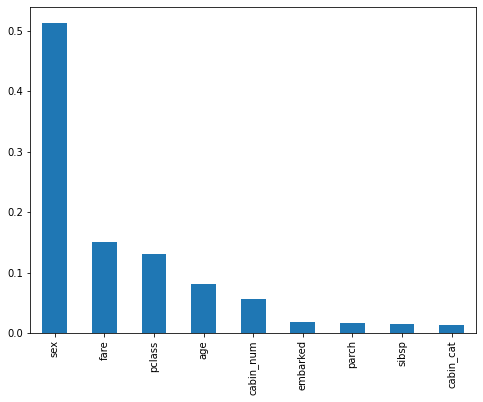

In [62]:
importance = pd.Series(titanic_pipe.named_steps['gbm'].feature_importances_)
importance.index = data.drop('survived', axis = 1).columns
importance.sort_values(ascending=False).plot.bar(figsize= (8,6))
plt.show();